In [1]:
## Version futuresales lib required = 0.1.8

# !pip install -i https://test.pypi.org/simple/ futuresales_denissimo==0.1.8
# !pip install plotly==5.3.1
# !pip install neptune-client
# !pip install neptune-sklearn

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

import futuresales as fs

from futuresales.distribution import from_pickle, to_pickle
from futuresales.utils import make_scaled, load_credentials
from futuresales.validation import Validator

from neptune.new.types import File

/tmp/ipykernel_19613/2636906969.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [3]:
def get_statistics(report):
    stat = report[3]
    stat['residuals'] = report[2].transpose()[0] - report[3].valid_target
    stat['predicted'] = report[2]
    stat['object_id'] = report[3].index
    return stat

# Base neptune configuration

In [4]:
import neptune.new as neptune

cred = load_credentials('../../credentials.json')['projects']['fs-results']

run = neptune.init(
    api_token=cred['api_token'],
    project=cred['project'],
    tags=['linear', 'baseline']
)  # your credentials

Info (NVML): Driver Not Loaded. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/denissimo/FS-Results/e/FSRES-17
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


# Dataset preparation

In [5]:
task_df = {}

task_df['test'] = pd.read_csv('../../tmp/task_df_test.csv')
task_df['train'] = pd.read_csv('../../tmp/task_df_train.csv')
task_df['idx'] = pd.read_csv('../../tmp/idx.csv')

train = pd.read_csv('../../tmp/baseline_train_set.csv')
test = pd.read_csv('../../tmp/baseline_test_set.csv')
validation = pd.read_csv('../../tmp/baseline_validation_set.csv')

In [6]:
train_x = train.drop(['valid_target', 'target'], axis=1)
train_y = train.loc[:, ['target']]
train_y_valid = train.loc[:, ['valid_target']]

test_x = test.drop(['valid_target', 'target'], axis=1)
test_y = test.loc[:, ['target']]
test_y_valid = test.loc[:, ['valid_target']]

validation_x = validation.drop(['valid_target', 'target'], axis=1)
validation_y = validation.loc[:, ['target']]
validation_y_valid = validation.loc[:, ['valid_target']]

train_x = make_scaled(train_x).drop('id', axis=1).reset_index().rename({'index': 'id'}, axis=1).set_index('id')
test_x = make_scaled(test_x).drop('id', axis=1).reset_index().rename({'index': 'id'}, axis=1).set_index('id')
validation_x = make_scaled(validation_x).drop('id', axis=1).reset_index().rename({'index': 'id'}, axis=1).set_index('id')

# Model tuning

In [7]:
from sklearn.linear_model import Ridge, LinearRegression, Lasso, ElasticNet
import seaborn as sns


err = None
_list = [[], [], []]

for log_alpha in range(-12, 12):
    lin_validator = Validator(Ridge, alpha=10**log_alpha)

    lin_validator.fit(train_x, train_y)
    err = lin_validator.validate(test_x, test_y_valid)
    _list[0].append(log_alpha)
    _list[1].append(err[0])
    _list[2].append(err[1])

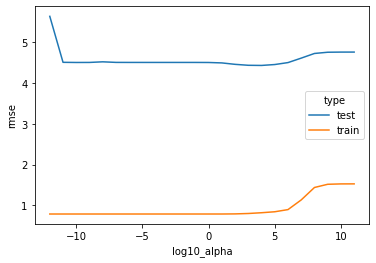

In [8]:
alpha_reg = pd.DataFrame(_list).transpose().rename(
    {
        0: 'log10_alpha',
        1: 'test',
        2: 'train'
    },
    axis=1
).set_index('log10_alpha').stack().reset_index().rename({'level_1': 'type', 0: 'rmse'}, axis=1)
hpo_fig = sns.lineplot(data=alpha_reg, x='log10_alpha', y='rmse', hue='type').figure
run['plots/reg'].upload(File.as_image(hpo_fig))

In [9]:
errors = {}

In [10]:
lin_validator = Validator(Ridge, alpha=10**4)

lin_validator.fit(test_x, test_y)
errors['ridge'] = lin_validator.validate(validation_x, validation_y_valid)
residulas = get_statistics(errors['ridge'])

run['params'] = {
    'alpha': 10000
}

run['score/rmse/test'] = errors['ridge'][0]
run['score/rmse/train'] = errors['ridge'][1]
run['model'] = 'Ridge'
run['dump/residuals'].upload(File.as_pickle(residulas))
run['dump/model'].upload(File.as_pickle(lin_validator))

/home/denissimo/Repo/fs_project/env/lib/python3.8/site-packages/yellowbrick/model_selection/importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


Did not log prediction error chart. Error: y must be a (1,) dimensional array not (422577, 1)
Did not log cooks distance chart. Error: shapes (422577,1) and (422577,1) not aligned: 1 (dim 1) != 422577 (dim 0)


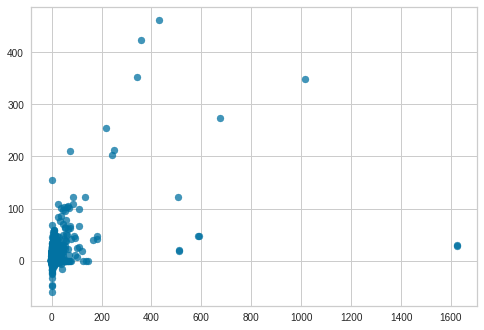

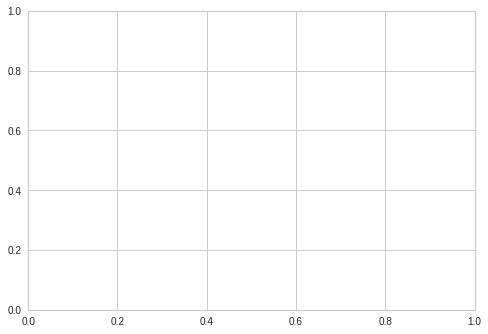

In [11]:
import neptune.new.integrations.sklearn as npt_utils

run['auto_model_summary'] = npt_utils.create_regressor_summary(
    lin_validator.model, 
    train_x, 
    test_x, 
    train_y.to_numpy(), 
    test_y_valid.to_numpy())

In [12]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 21 operations to synchronize with Neptune. Do not kill this process.


All 21 operations synced, thanks for waiting!
